In [1]:
# Analiza i modyfikacja danych
import pandas as pd
import numpy as np
import random
# Wizualizacja
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Ewaluacja
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, accuracy_score

random.seed(71830)

In [2]:
# wczytujemy dane
train_df = pd.read_csv('Data/train.csv')
train_df = train_df.drop(['PassengerId'], axis=1)

## Nasz zbiór Dane o pasażerach Titanic'a
| Zmienna | Definicja | Klucz |
|---------|-----------|-------|
|Survival| Czy ktoś przeżył|0 = Nie, 1 = Tak|
|pclass| Jakiej klasy bilet posiadał |1-pierwsza 2-druga 3-trzecia|
|Sex|płeć||
|Age|wiek||
|Sibsp|liczba rodzeństwa/małżonków na statku||
|Parch|Liczba rodziców/dzieci na statku||
|Ticket|numer biletu||
|Fare|opłata pasażerska||
|Cabin|Numer kabiny||
|Embarked|Port na którym dana osoba wsiadła| C = Cherbourg, Q = Queenstown, S = Southampton|


In [3]:
# sprawdzamy jakie kolumny występują w naszych danych
print(train_df.columns.values)

['Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [4]:
# podglądamy pierwsze 5 wyciągów z tabeli
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# sprawdzamy ile mamy nie uzupełnionych pól w Danych
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


## Podział zmiennych 
* Ilościowe (Numerical Variables) np. Wzrost, koszt mieszkania, liczba uczestników.
* Zmienne Kategoryczne (Categorical Variables)
    * Nominalne (Nominal Variables) zwane też zmiennymi jakościowymi nie uporządkowanymi np. marka samochodu
    * Uporządkowane (Ordinal Variable) np. wykształcenie, twardość materiału

In [6]:
# Patrzymy jaka jest średnia, odchylenie standardowe oraz kwartyle naszych danych liczbowych
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# Sprawdzamy jak wyglądają dane Kategoryczne
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Panula, Mr. Ernesti Arvid",male,347082,G6,S
freq,1,577,7,4,644


# Co to [korelacja](https://pl.wikipedia.org/wiki/Korelacja)?

Korelację między dwoma zmiennymi X i Y wyliczamy następująco:
$$r_{XY}\frac{cov(X,Y)}{\sigma(X)\sigma(Y)}$$
Gdzie $\sigma(X)$ to odchylenie standardowe zmiennej X 
a cov(X,Y) to kowariancja zmiennych X i Y wyrażona wzorem:
$$cov(X,Y) = E(X\cdot Y)-EX\cdot EY$$
Gdzie EX to wartość oczekiwana X

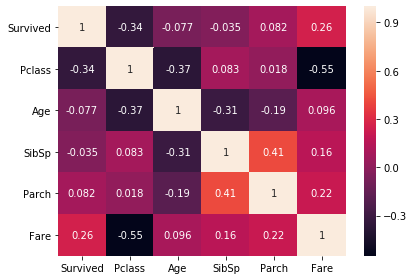

In [8]:
# patrzymy jak skorelowane są dane numeryczne
sns.heatmap(train_df.corr(), annot=True)
plt.tight_layout()

In [9]:
# Patrzymy jaki procent osób z każdej klasy przeżył
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [10]:
# Sprawdzamy jaki procent mężczyzn oraz kobiet przeżył
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived',
                                                                                  ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [11]:
# Grupujemy ludzi ze względu na liczbę rodzeństwa/małżonków i sprawdzamy jaki procent przeżył
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived',
                                                                                      ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [12]:
# Grupujemy ludzi ze względu na liczbę rodziców/dzieci i sprawdzamy jaki procent przeżył
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived',
                                                                                      ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


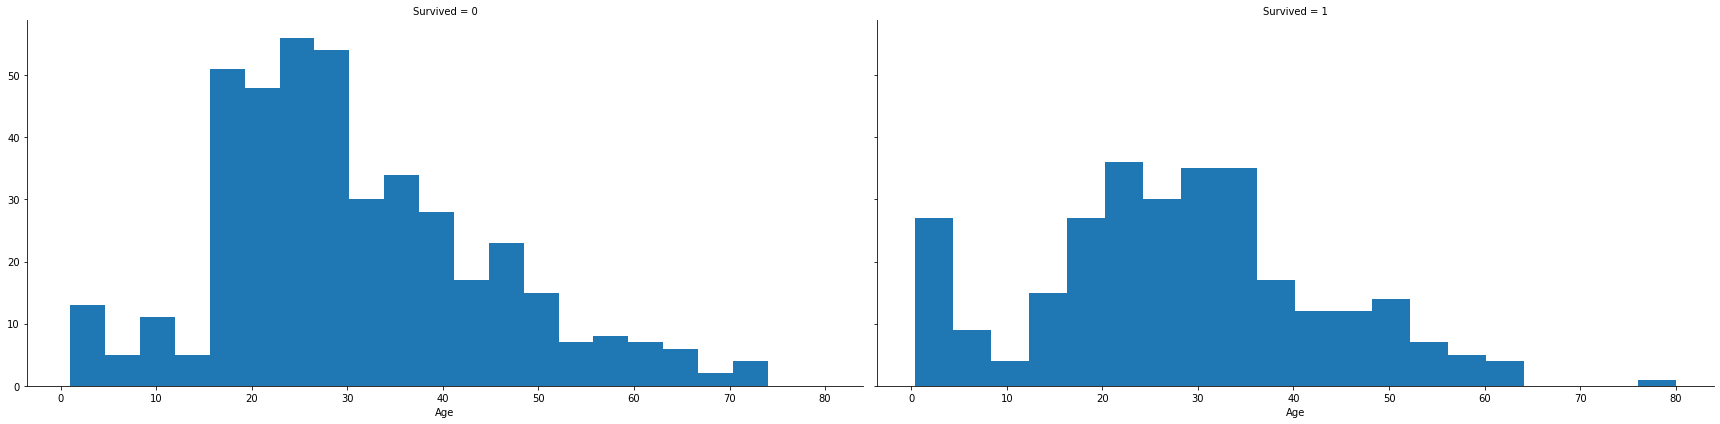

In [13]:
# Wykreślamy rozkład wieku osób, które przeżyły i nie
g = sns.FacetGrid(train_df, col='Survived', height=6, aspect=2)
g.map(plt.hist, 'Age', bins=20);

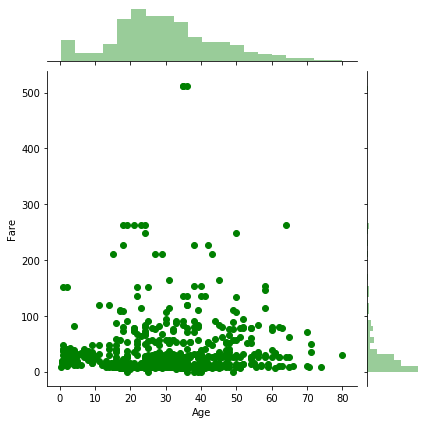

In [14]:
# Wykreślamy wykres zależności wieku od opłaty pasażerskiej wraz z rozkładami obu zmiennych
sns.jointplot(x='Age', y='Fare', data=train_df, color='g');

# Co To [BoxPlot](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)?

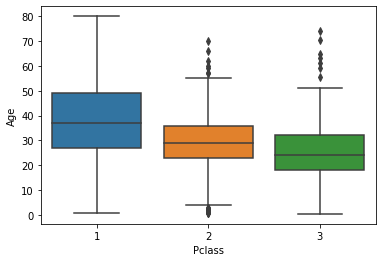

In [15]:
# Wykreślamy Box Ploty
sns.boxplot(x='Pclass', y='Age', data=train_df);

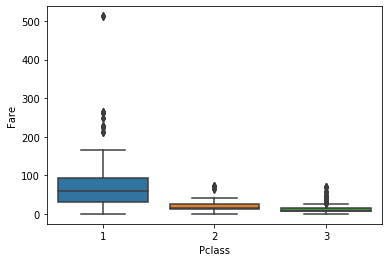

In [16]:
sns.boxplot(x='Pclass', y='Fare', data=train_df);

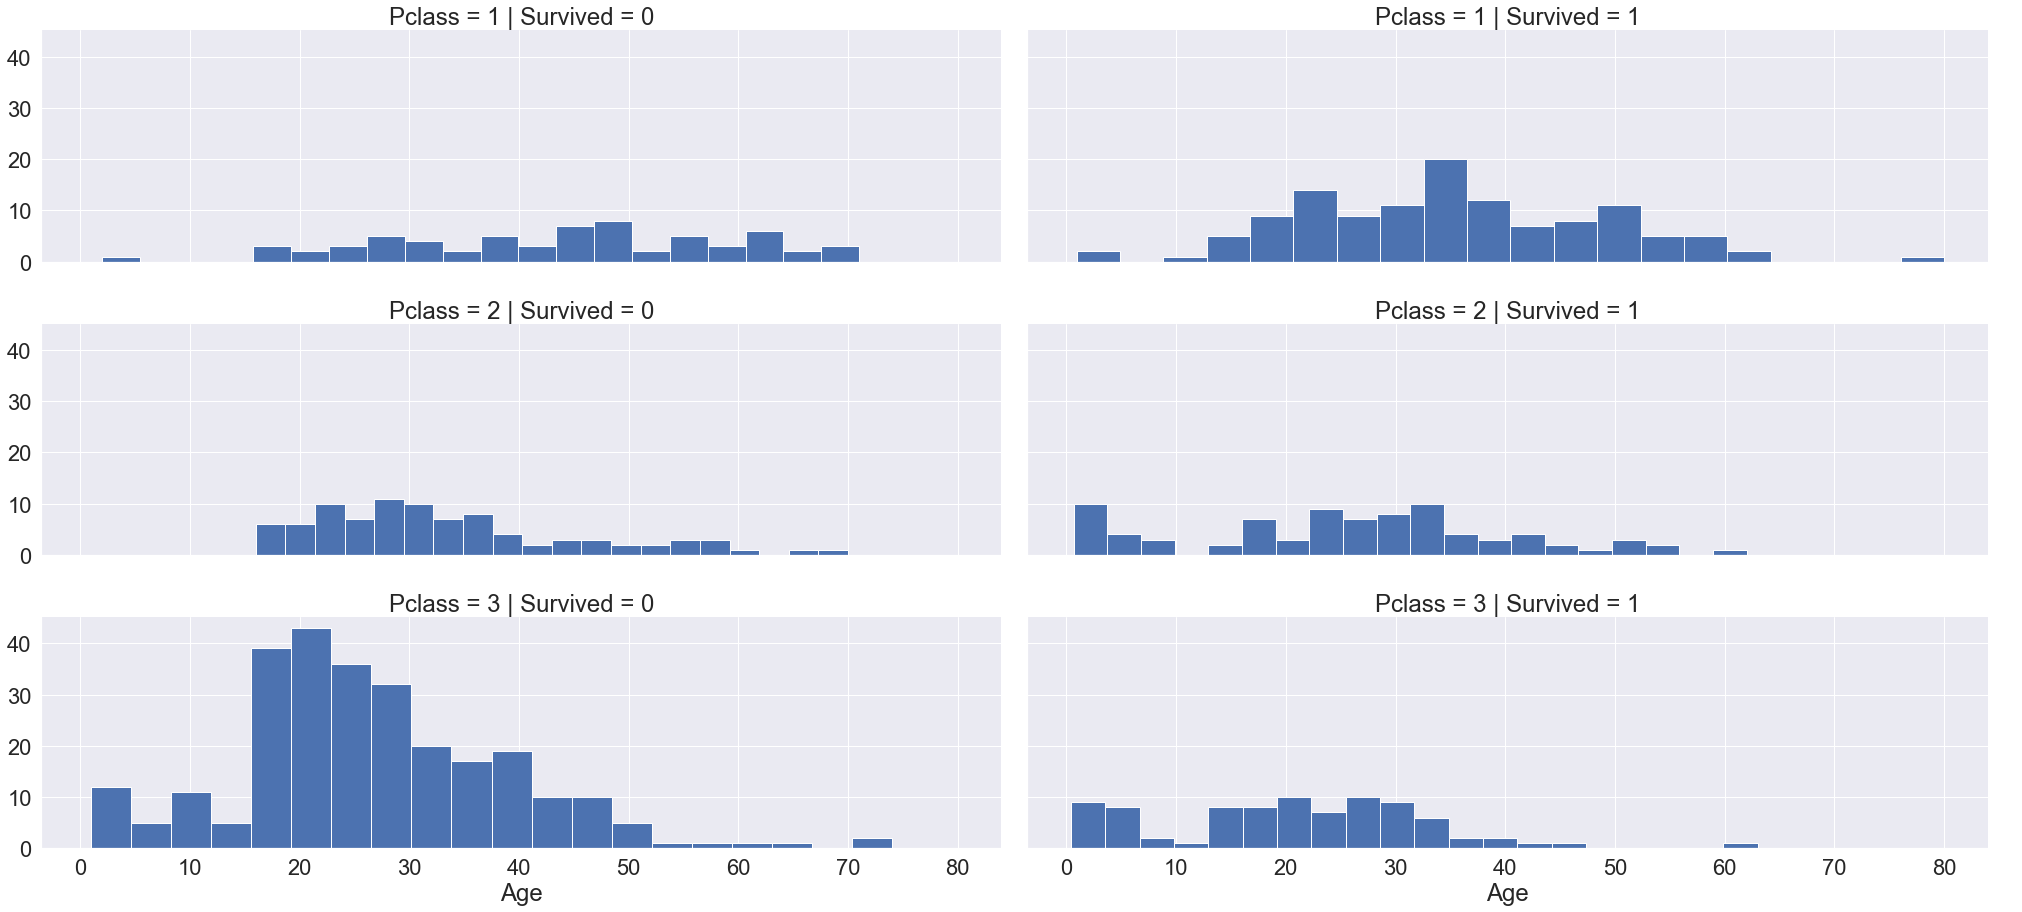

In [17]:
# Wykreślamy rozkłady dla róznych klas biletu
sns.set(font_scale=2)
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=4.4, aspect=3.2)
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend();

c:\users\macie\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\users\macie\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


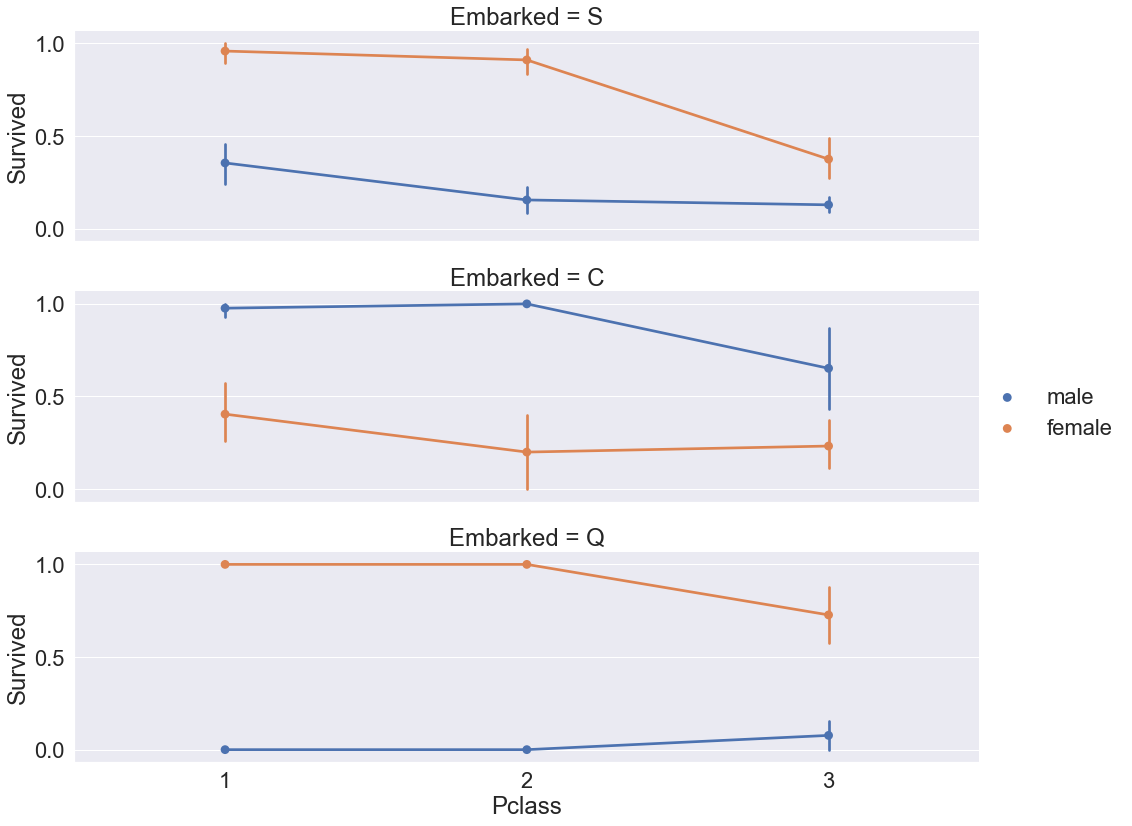

In [18]:
# Wykreślamy wykresy przeżycia w zależności od klasy pasażerskiej dla różnych miejsc,
# w których pasażerowie wsiedli
grid = sns.FacetGrid(train_df, row='Embarked', height=4, aspect=3.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend();

In [19]:
# Dane o bilecie oraz kabinie nic nie wnoszą co do przeżycia więc je odrzucamy
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)

In [20]:
# wydobywamy z imion przedrostki typu Mr, Ms, Master itd.
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [21]:
# Zastępujemy rzadko występujące przedrostki nazwą Other oraz poprawiamy inne przedrostki
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir',\
                                                 'Jonkheer', 'Dona'], 'Rare')

train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')
# Wyliczamy średnie przeżycie dla róznych tytułów    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [22]:
# Odrzucamy imiona ponieważ już nic nie wnosi.
train_df = train_df.drop(['Name'], axis=1)

In [23]:
# Wyciągamy zmienną którą nasz model będzie przewidywał
Y = train_df['Survived'].values

In [24]:
train_df = train_df.drop(['Survived'], axis=1)

In [25]:
# Sprawdzamy ile danych nam brakuje w każdej kolumnie
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
Title       891 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


In [26]:
# uzupełniamy wiek średnią
age_mean = np.mean(train_df['Age'])
train_df['Age'] = train_df[['Age']].fillna(age_mean)

# pozostałe zastępujemy flagą missing
train_df = train_df.fillna('missing')

print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
Title       891 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB
None


In [27]:
# Kodujemy zmienne kategoryczne
categoricals = list(train_df.select_dtypes(include=['O']).columns) + ['Pclass']
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(train_df[categoricals])
# Tworzymy data frame z zakodowanymi zmiennymi a następnie dodajemy go do naszego
# i usuwamy zmienne niezakodowane
train_ohe = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
train_df = pd.concat((train_df, train_ohe), axis=1).drop(categoricals, axis=1)

In [28]:
# Dokonujemy podziału danych na zbiór uczący i testujący
X = train_df.values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=71830)

# Drzewo Decyzyjne

## Drzewo wyuczone do rozpoznawania rodzaju kwiata Irys
![](https://www.kdnuggets.com/wp-content/uploads/dt-iris-interpretability.jpg)

Drzewo podczas nauki stara się jak najlepiej rodzielić klasy, które mu podano w danych treningowych. Wykorzystując metrykę entropii (lub Gini) znajduje wartość rozdzielającą (np. szerokość kwiata, lub po prostu jakaś zmienna mówiąca tak lub nie), dla której podzielenie zbiorów (na zbiór, którego ta wartość jest mniejsza i większa od wartości rozdzielającej lub zbiór, dla którego ta wartość to tak i zbiór z wartością nie) najlepiej rozdzieli klasy do oddzielnych zbiorów.

In [29]:
# Tworzymy nasz model i uczymy go na danych treningowych
model = DecisionTreeClassifier(random_state=71830)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=71830, splitter='best')

In [30]:
# Dajemy naszemu modelowi dane do przewidzenia i porównujemy wyniki z rzeczywistymi
def calculate_metrics(model, X_test, y_test):
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    acc = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f_score = f1_score(y_test, pred)
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nF1_score: {}'.format(
        acc, precision, recall, f_score))
    return cm

# Czym tak naprawdę są te metryki?
* True Positive (TP) - liczba poprawnie przewidzianych 1 przez model
* False Positive (FP) - ile razy model przewidział 1 kiedy rzeczywista wartość to 1
* True Negative (TN) - liczba poprawie przewidzianych 0 przez model
* False Negative (FN) - ile razy model przewidział 0 kiedy rzeczywista wartość to 1
* Condition Positive (P) - liczba prawdziwych 1 w danych
* Condition Negative (N) - liczba prawdziwych 0 w danych
* Accuracy = $\frac{TP+TN}{P+N}$
* Recall (True Positive Rate/sensitivity) = $\frac{TP}{TP+FN}$
* Precision = $\frac{TP}{TP+FP}$
* Fscore (Harmonic mean of precision and recall)= $\frac{2TP}{2TP+FP+FN}$

### Macierz pomyłek Confusion Matrix

|-|Predykcja|-|
|-|-|-|
|Rzeczywiste wartości|0|1|
|0|TN|FP|
|1|FN|TP|
|-|0|1|

Accuracy: 0.770949720670391
Precision: 0.75
Recall: 0.6575342465753424
F1_score: 0.7007299270072993


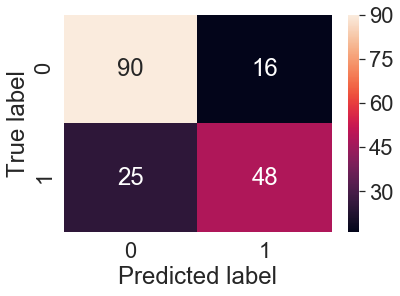

In [31]:
# Wyświetlamy macierz pomyłek oraz wartości metryk
cm = calculate_metrics(model, X_test, y_test)
sns.heatmap(cm, annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [32]:
# Sprawdzamy jak głębokość drzewa wpływa na wyniki modelu
max_depths = [2*x for x in range(1,9)]
for max_depth in max_depths:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=71830)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train) > 0.5
    test_pred = model.predict(X_test) > 0.5
    print('Model params: max_depth:{}'.format(max_depth))
    print('Train_acc: {}\tTest_acc: {}'.format(accuracy_score(y_train, train_pred), accuracy_score(y_test, test_pred)))

Model params: max_depth:2
Train_acc: 0.8019662921348315	Test_acc: 0.7374301675977654
Model params: max_depth:4
Train_acc: 0.851123595505618	Test_acc: 0.7988826815642458
Model params: max_depth:6
Train_acc: 0.8848314606741573	Test_acc: 0.8044692737430168
Model params: max_depth:8
Train_acc: 0.9101123595505618	Test_acc: 0.8212290502793296
Model params: max_depth:10
Train_acc: 0.9367977528089888	Test_acc: 0.7821229050279329
Model params: max_depth:12
Train_acc: 0.9550561797752809	Test_acc: 0.776536312849162
Model params: max_depth:14
Train_acc: 0.9705056179775281	Test_acc: 0.7877094972067039
Model params: max_depth:16
Train_acc: 0.9789325842696629	Test_acc: 0.7597765363128491


In [33]:
# Sprawdzamy jak minimalna liczba próbek do podziału drzewa wpływa na wynik
min_samples_splits = [5*x for x in range(1,15,2)]
for min_sample in min_samples_splits:
    model = DecisionTreeClassifier(min_samples_split=min_sample, random_state=71830)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train) > 0.5
    test_pred = model.predict(X_test) > 0.5
    print('Model param: min_samples_split:{}'.format(min_sample))
    print('Train_acc: {}\tTest_acc: {}'.format(accuracy_score(y_train, train_pred), accuracy_score(y_test, test_pred)))

Model param: min_samples_split:5
Train_acc: 0.9480337078651685	Test_acc: 0.7597765363128491
Model param: min_samples_split:15
Train_acc: 0.901685393258427	Test_acc: 0.8044692737430168
Model param: min_samples_split:25
Train_acc: 0.8862359550561798	Test_acc: 0.8324022346368715
Model param: min_samples_split:35
Train_acc: 0.8735955056179775	Test_acc: 0.7932960893854749
Model param: min_samples_split:45
Train_acc: 0.8693820224719101	Test_acc: 0.7988826815642458
Model param: min_samples_split:55
Train_acc: 0.8637640449438202	Test_acc: 0.7988826815642458
Model param: min_samples_split:65
Train_acc: 0.8609550561797753	Test_acc: 0.7988826815642458


# Automatyczne wyszukiwanie Hiperparametrów

In [34]:
# Tworzymy słownik z różnymi wartościami dla parametrów
parameters = {'criterion': ['entropy', 'gini'],
              'min_samples_split': [5*x for x in range(1,15,2)],
              'min_samples_leaf': [2*x+1 for x in range(14)],
              'max_leaf_nodes': [2*x for x in range(1, 9)],
              'max_depth': [2*x for x in range(1,9)]}

In [35]:
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=71830), param_grid=parameters, cv=3)
# Dokonujemy przeszukiwania po wszystkich możliwościach parametrów
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=71830,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
        

In [36]:
# Wyświetlamy najlepsze parametry
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 16, 'min_samples_leaf': 5, 'min_samples_split': 5}


Accuracy: 0.8212290502793296
Precision: 0.8253968253968254
Recall: 0.7123287671232876
F1_score: 0.7647058823529411


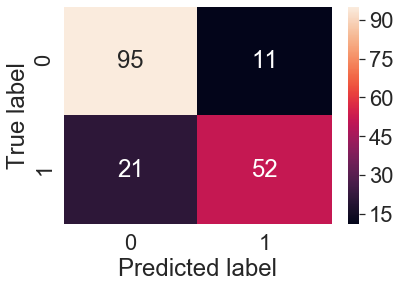

In [37]:
# Sprawdzamy jaki będzie wynik dla najlepszego modelu
best_model = DecisionTreeClassifier(**grid_search.best_params_)
best_model.fit(X_train, y_train)

cm = calculate_metrics(best_model, X_test, y_test)
sns.heatmap(cm, annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label');

Accuracy: 0.8100558659217877
Precision: 0.7910447761194029
Recall: 0.726027397260274
F1_score: 0.757142857142857


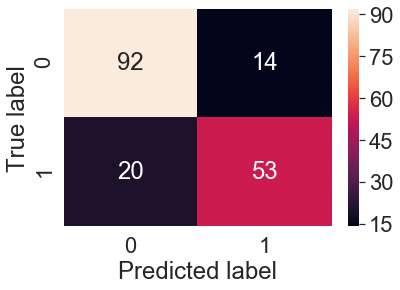

In [38]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test) > 0.5
cm = confusion_matrix(y_test, pred)
acc = accuracy_score(y_test, pred)
precision, recall, fscore = precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred)

print('Accuracy: {}\nPrecision: {}\nRecall: {}\nF1_score: {}'.format(
        acc, precision, recall, fscore))
sns.heatmap(cm, annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# Co dalej?
* [Poradnik do Pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/tutorials.html)
* [Auc/Roc](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
* [Jak działa drzewo decyzyjne](https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248)
* [Bardziej zaawansowne metody w Pandas](https://towardsdatascience.com/learn-advanced-features-for-pythons-main-data-analysis-library-in-20-minutes-d0eedd90d086)
* [Wizualizacja](https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d)